Results for:

In [1]:
AGENT_NAME = 'default_PPO_citylearn_challenge_2022_phase_2_Building_6_20_bins_500'
DATASET_NAME = 'citylearn_challenge_2022_phase_2' #only action is electrical storage

In [2]:
from stable_baselines3 import PPO

from citylearn.data import DataSet

from art.attacks.evasion import AutoConjugateGradient as ACG

import pandas as pd
import numpy as np

import KBMproject.utilities as utils

%matplotlib inline

In [3]:
schema = DataSet.get_schema(DATASET_NAME)

Define RL agent

In [4]:
agent = PPO.load(path=f"{AGENT_NAME}")
print('Model loaded from storage')

Model loaded from storage


In [5]:
bins = agent.action_space[0].n
env = utils.make_discrete_env(schema=schema,  
                        action_bins=bins,
                        seed=42)

Unperturbed agent performance

In [6]:
baseline_kpis, baseline_obs, baseline_a = utils.eval_agent(env,agent)
display(baseline_kpis)

cost_function
annual_peak_average                      1.102271
carbon_emissions_total                   0.869186
cost_total                               0.787803
daily_one_minus_load_factor_average      1.095762
daily_peak_average                       0.894595
electricity_consumption_total            0.879108
monthly_one_minus_load_factor_average    0.988364
ramping_average                          1.093749
zero_net_energy                          1.107710
Name: District, dtype: float64

We will use feature permutations to determine attribute the importance of each feature. 
- The Battery's charge and time of day are by far the most important features for this model.
- Time features have higher importance the the power consumed by the non-shiftable load, suggesting the model has learned a schedule.
- It's strange that solar irradience features are just below most time features, but solar generation has the second lowest importance. I suspect that these feature are correlated with the hour and season (month), and are considered similar by the model.
- the same may be true of electricity pricing (cost is not part of the reward)
- Because the agent doesn't control the interior climate the related power consumption is capture by the non-shiftable load, it's understand able that the outdoor temperatures and humidities are not important.
- Considering that the reward function is -net-electricity consummption, it's odd that it is the least important feature. I suspect it's value and solar generation are very small portions of the non shiftable load, are are not significant when considered next to it. I suspect this would be different for an agent controlling a larger proportion solar and storage capacities

In [7]:
observation_names = env.observation_names[0]

In [8]:
attributions = utils.get_feature_permutations(agent, baseline_obs, baseline_a)
attributions = pd.Series(attributions, index=observation_names)
display(attributions.sort_values(ascending=False))

hour_cos                                      2.124443
electrical_storage_soc                        2.089399
month_cos                                     1.228654
day_type_sin                                  1.206183
non_shiftable_load                            1.139838
day_type_cos                                  1.059757
hour_sin                                      1.014108
diffuse_solar_irradiance_predicted_24h        0.912697
diffuse_solar_irradiance                      0.854898
direct_solar_irradiance_predicted_12h         0.848541
direct_solar_irradiance_predicted_24h         0.727101
electricity_pricing_predicted_12h             0.685736
direct_solar_irradiance                       0.657724
direct_solar_irradiance_predicted_6h          0.561453
diffuse_solar_irradiance_predicted_12h        0.490166
month_sin                                     0.475555
electricity_pricing                           0.471677
electricity_pricing_predicted_6h              0.450410
electricit

In [9]:
df_baseline_obs = pd.DataFrame(baseline_obs, columns=observation_names)

Using correlation matrices, we can test the correlations between date/time, and solar irradience, or prices:

The current and 24h forcsts are relatively important features. 

In [10]:
mask = df_baseline_obs.columns.str.contains('day|hour|month|diffuse')
df_baseline_obs.loc[:,mask].corr()[['diffuse_solar_irradiance_predicted_24h','diffuse_solar_irradiance']]

,diffuse_solar_irradiance_predicted_24h,diffuse_solar_irradiance
month_cos,-0.229864,-0.228673
month_sin,-0.042792,-0.046002
day_type_cos,-0.012862,-0.018395
day_type_sin,0.014413,-0.001114
hour_cos,-0.795924,-0.795924
hour_sin,-0.120515,-0.120515
diffuse_solar_irradiance,0.939275,1.000000
diffuse_solar_irradiance_predicted_6h,-0.088482,-0.083468
diffuse_solar_irradiance_predicted_12h,-0.503596,-0.503596
diffuse_solar_irradiance_predicted_24h,1.000000,0.939275


We see that the direct irradience features have a strong relationship of +/- 0.72 with the high importance hour features. In particular, all but the 6h forces exhibit this relationship with the hour_sin which is the second most important feature.

In [11]:
mask = df_baseline_obs.columns.str.contains('day|hour|month|direct')
df_baseline_obs.loc[:,mask].corr().iloc[:,6:] #iloc to ignore the date/time columns

,direct_solar_irradiance,direct_solar_irradiance_predicted_6h,direct_solar_irradiance_predicted_12h,direct_solar_irradiance_predicted_24h
month_cos,-0.092103,-0.092098,-0.092017,-0.092917
month_sin,-0.053146,-0.053101,-0.052739,-0.051987
day_type_cos,-0.034763,-0.034450,-0.024613,-0.013759
day_type_sin,0.011084,0.011586,0.023050,0.033253
hour_cos,-0.723250,-0.139010,0.723191,-0.723250
hour_sin,-0.139131,0.723256,0.139219,-0.139131
direct_solar_irradiance,1.000000,-0.005227,-0.455574,0.746135
direct_solar_irradiance_predicted_6h,-0.005227,1.000000,-0.005015,-0.037766
direct_solar_irradiance_predicted_12h,-0.455574,-0.005015,1.000000,-0.455574
direct_solar_irradiance_predicted_24h,0.746135,-0.037766,-0.455574,1.000000


The most important pricing features were the current and 12h forecast values, below we see the 12h forecast has a 0.67 correlation, and the current -0.67, with the hour_cos. this indicates a relationship between those two features.

In [12]:
mask = df_baseline_obs.columns.str.contains('day|hour|month|pricing')
df_baseline_obs.loc[:,mask].corr()[['electricity_pricing_predicted_12h','electricity_pricing']]

,electricity_pricing_predicted_12h,electricity_pricing
month_cos,-0.018952,-0.018809
month_sin,-0.019185,-0.019432
day_type_cos,-0.018258,-0.018258
day_type_sin,0.026370,0.026153
hour_cos,0.000070,0.000070
hour_sin,0.669545,-0.669583
electricity_pricing,-0.256670,1.000000
electricity_pricing_predicted_6h,-0.256660,-0.256660
electricity_pricing_predicted_12h,1.000000,-0.256670
electricity_pricing_predicted_24h,-0.256670,0.986212


the non shiftable load is does not have a strong correlation with any feature, excluding net electircity consumption (which is the load plus the imfluence of storage and solar generation).

In [13]:
df_baseline_obs.corr()['non_shiftable_load'].sort_values(ascending=False)

non_shiftable_load                            1.000000
net_electricity_consumption                   0.770537
month_cos                                     0.261376
carbon_intensity                              0.212829
electricity_pricing_predicted_24h             0.171228
electricity_pricing                           0.170560
outdoor_dry_bulb_temperature_predicted_24h    0.107856
outdoor_dry_bulb_temperature                  0.106429
direct_solar_irradiance_predicted_24h         0.105122
direct_solar_irradiance                       0.099503
outdoor_relative_humidity_predicted_12h       0.097260
outdoor_relative_humidity_predicted_6h        0.087507
diffuse_solar_irradiance                      0.075103
diffuse_solar_irradiance_predicted_24h        0.073790
electrical_storage_soc                        0.073244
day_type_cos                                  0.062731
electricity_pricing_predicted_6h              0.039732
solar_generation                             -0.010430
outdoor_dr

In [14]:
plot_len = 400

<Axes: >

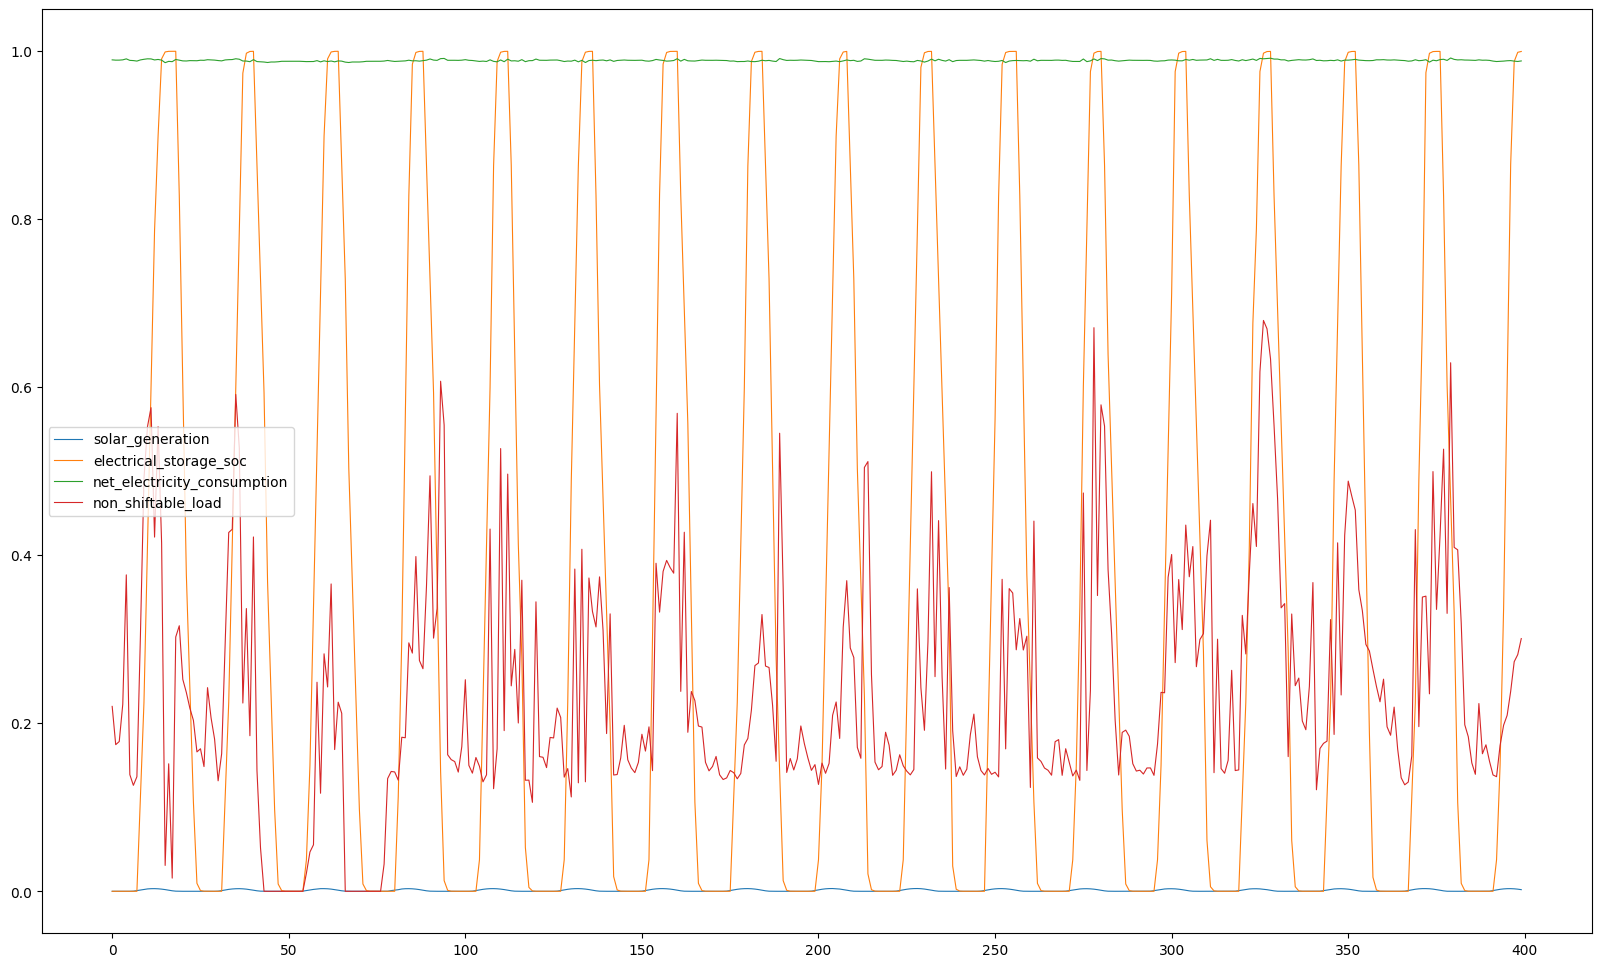

In [15]:
df_baseline_obs[[#'outdoor_dry_bulb_temperature',
                 'solar_generation',
                 'electrical_storage_soc',
                 'net_electricity_consumption',
                 'non_shiftable_load',
                 #'electricity_pricing'
                 ]][:plot_len].plot.line(figsize=(20,12), lw=0.8)

Model performance while observations are perturbed by random noise [0,1). Note that all the observation values are normalized to [0,1]

epsilon of 5% has an asr of ~92% with ACG

In [16]:
rand_kpis, rand_obs, rand_a = utils.eval_rand_attack(agent, env, eps=0.05)


The Adversarial success rate is: 0.12808219178082192


Here's the regret for the random attack:

In [17]:
display(baseline_kpis - rand_kpis)

cost_function
annual_peak_average                      0.092933
carbon_emissions_total                  -0.001743
cost_total                               0.001336
daily_one_minus_load_factor_average      0.004174
daily_peak_average                      -0.002186
electricity_consumption_total           -0.002284
monthly_one_minus_load_factor_average    0.007058
ramping_average                         -0.011466
zero_net_energy                         -0.000202
Name: District, dtype: float64

In [18]:
df_rand_obs = pd.DataFrame(rand_obs, columns=observation_names)

<Axes: >

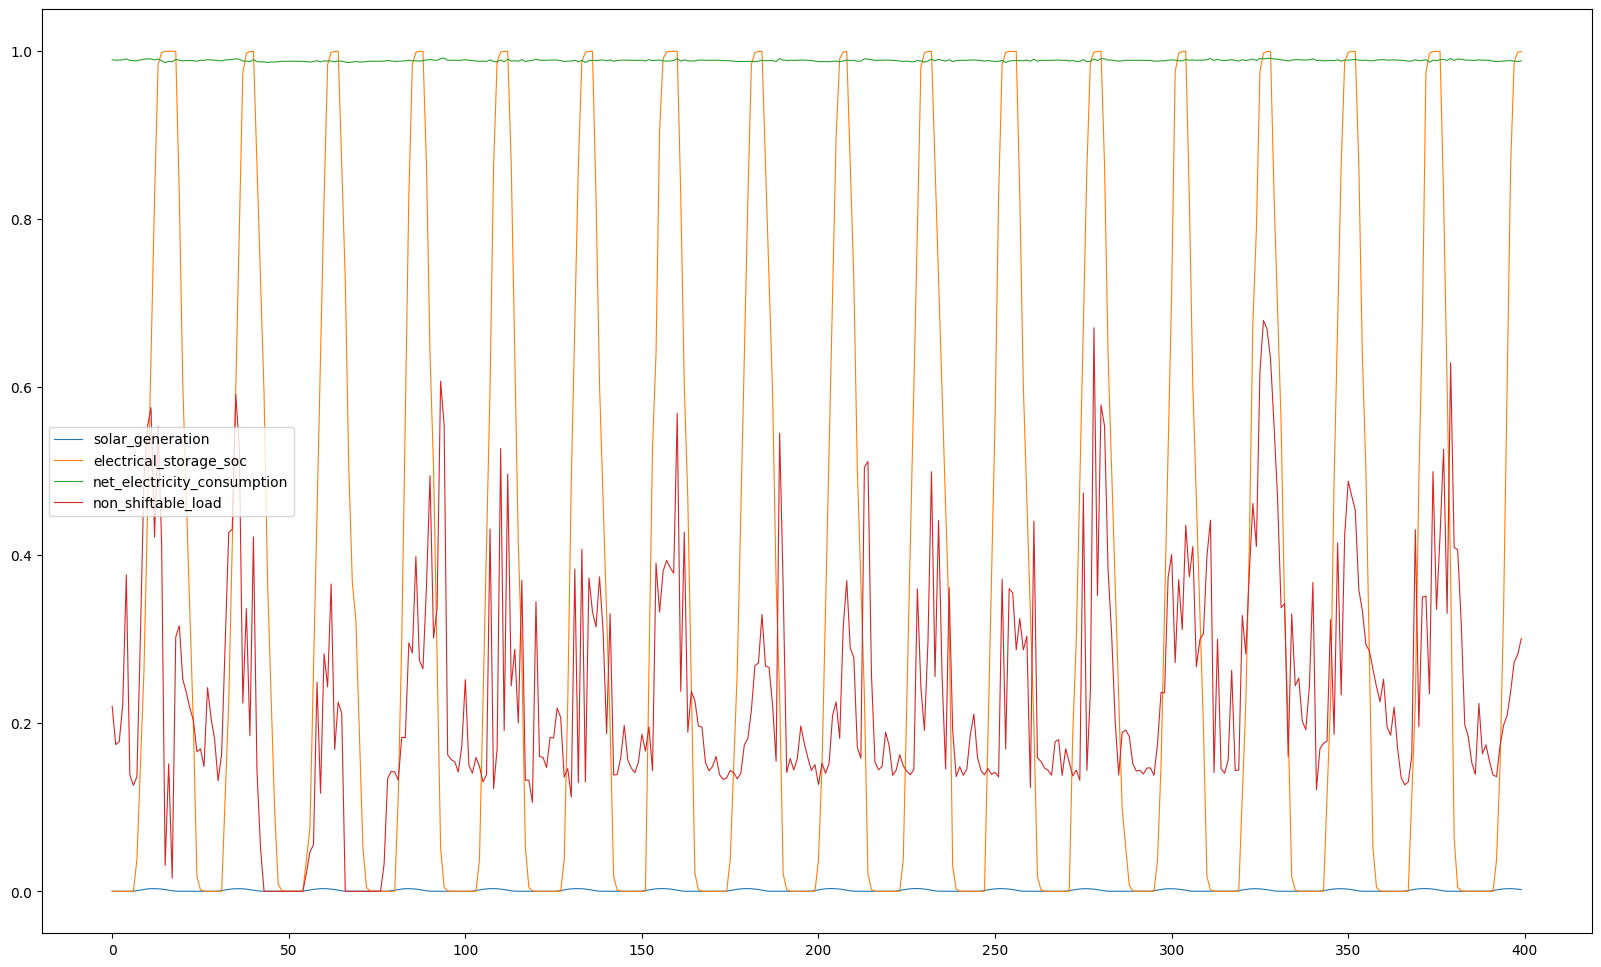

In [19]:
df_rand_obs[[#'outdoor_dry_bulb_temperature',
                 'solar_generation',
                 'electrical_storage_soc',
                 'net_electricity_consumption',
                 'non_shiftable_load',
                 #'electricity_pricing'
                 ]][:plot_len].plot.line(figsize=(20,12), lw=0.8)

<Axes: >

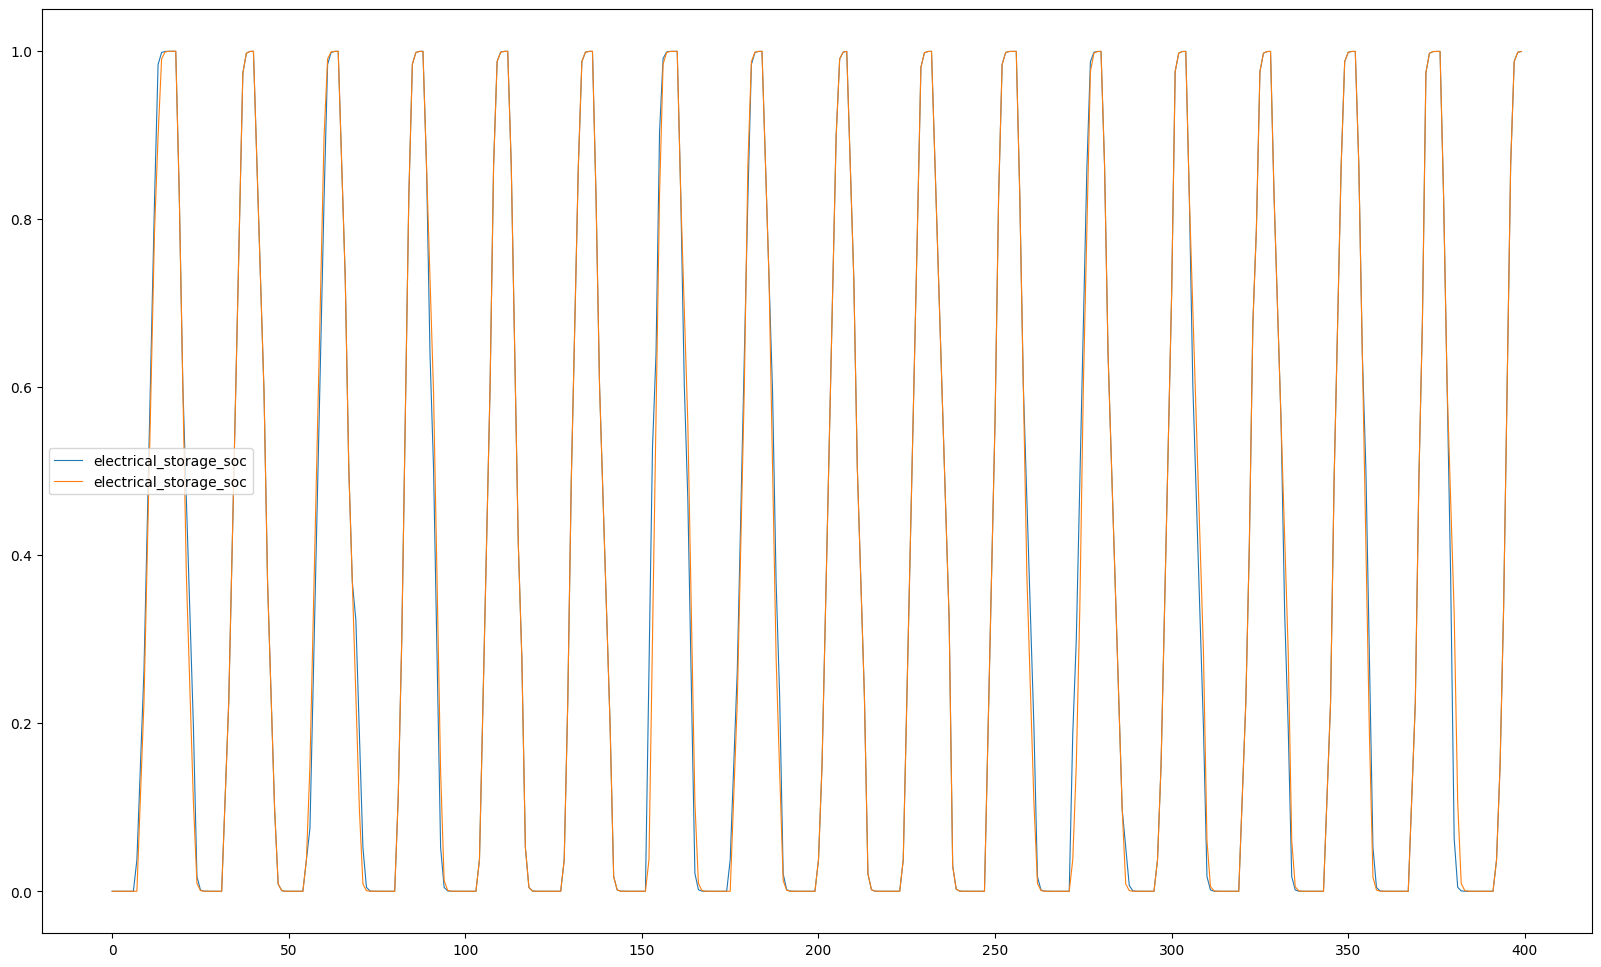

In [20]:
pd.concat([df_rand_obs['electrical_storage_soc'], df_baseline_obs['electrical_storage_soc']], axis=1)[:plot_len].plot.line(figsize=(20,12), lw=0.8)

Define our gradient based attack:

Before attacking the victim, we must understand what we are perturbing. So we need to see which observations/features are active in the environment (NB that periodically normalized calendar features are not properly named by the environment, so we will do it ourselves ref: https://github.com/intelligent-environments-lab/CityLearn/issues/74 ):

In [21]:
observation_masks = pd.Series(1, index=env.observation_names[0]).to_frame(name='all')

It seems that all these observations are variable (changes to constant values would indicate perturbations), however perturbations to the date and time would be obvious to an analyst. We will mask these features in our attack so they will not be perturbed.

In [22]:
observation_masks['mask_time'] = observation_masks['all']
observation_masks['mask_time'][observation_masks.index.str.contains('month|day|hour')] = 0

In [23]:
observation_masks

,all,mask_time
month_cos,1,0
month_sin,1,0
day_type_cos,1,0
day_type_sin,1,0
hour_cos,1,0
hour_sin,1,0
outdoor_dry_bulb_temperature,1,1
outdoor_dry_bulb_temperature_predicted_6h,1,1
outdoor_dry_bulb_temperature_predicted_12h,1,1
outdoor_dry_bulb_temperature_predicted_24h,1,1


Plot for preliminary results:
- outdoor_dry_bulb_temperature
- solar_generation
- electrical_storage_soc
- net_electricity_consumption
- electricity_pricing
- calculate power from grid/aggregate load

The adversarial regret from the untargeted adversarial attack is:

We could mask other features where tampering would be obvious e.g. temperture predictions vary between observations, but pricing predictions are identical for many obvservations and vary predictably.

In [24]:
init = 50
iter = int(500/init)
ACG_parameters = dict(
    loss_type='difference_logits_ratio', 
    batch_size=1,
    nb_random_init=init, #5, lower values speed crafting
    max_iter=iter, #iterations per restart
    norm='inf', #->l2 ->l1 most restrictive 
)
eps_list = [0.01, 0.03, 0.05, 0.07]

In [25]:

Adv_untargered_kpis, adv_obs, adv_untargeted_eps = utils.eval_untargeted_dynamic_distortion_attack(agent,
                                                        env,
                                                        ART_atk=ACG,
                                                        ART_atk_kwargs=ACG_parameters,
                                                        eps_candidates=eps_list,
                                                        time_steps=None,
                                                        mask=observation_masks['mask_time'].to_numpy())
display(Adv_untargered_kpis)

100%|█████████▉| 8758/8759 [3:48:46<00:01,  1.57s/it]  


The Adversarial success rate is: 0.990752368991894
The average distance between optinmal and adversarial actions is: 2.6291814134033564


cost_function
annual_peak_average                      1.198347
carbon_emissions_total                   0.902045
cost_total                               0.816997
daily_one_minus_load_factor_average      0.397182
daily_peak_average                       0.961207
electricity_consumption_total            0.910717
monthly_one_minus_load_factor_average    0.992850
ramping_average                          1.271853
zero_net_energy                          1.108499
Name: District, dtype: float64

In [26]:
s_adv_untargeted_eps = pd.Series(adv_untargeted_eps)

In [27]:
s_adv_untargeted_eps.value_counts()

0.01    4034
0.03    3593
0.05     862
0.07     189
dtype: int64

In [28]:
s_adv_untargeted_eps.describe()

count    8678.000000
mean        0.023561
std         0.014801
min         0.010000
25%         0.010000
50%         0.030000
75%         0.030000
max         0.070000
dtype: float64

In [29]:
df_adv_obs = pd.DataFrame(adv_obs, columns=observation_names)

<Axes: >

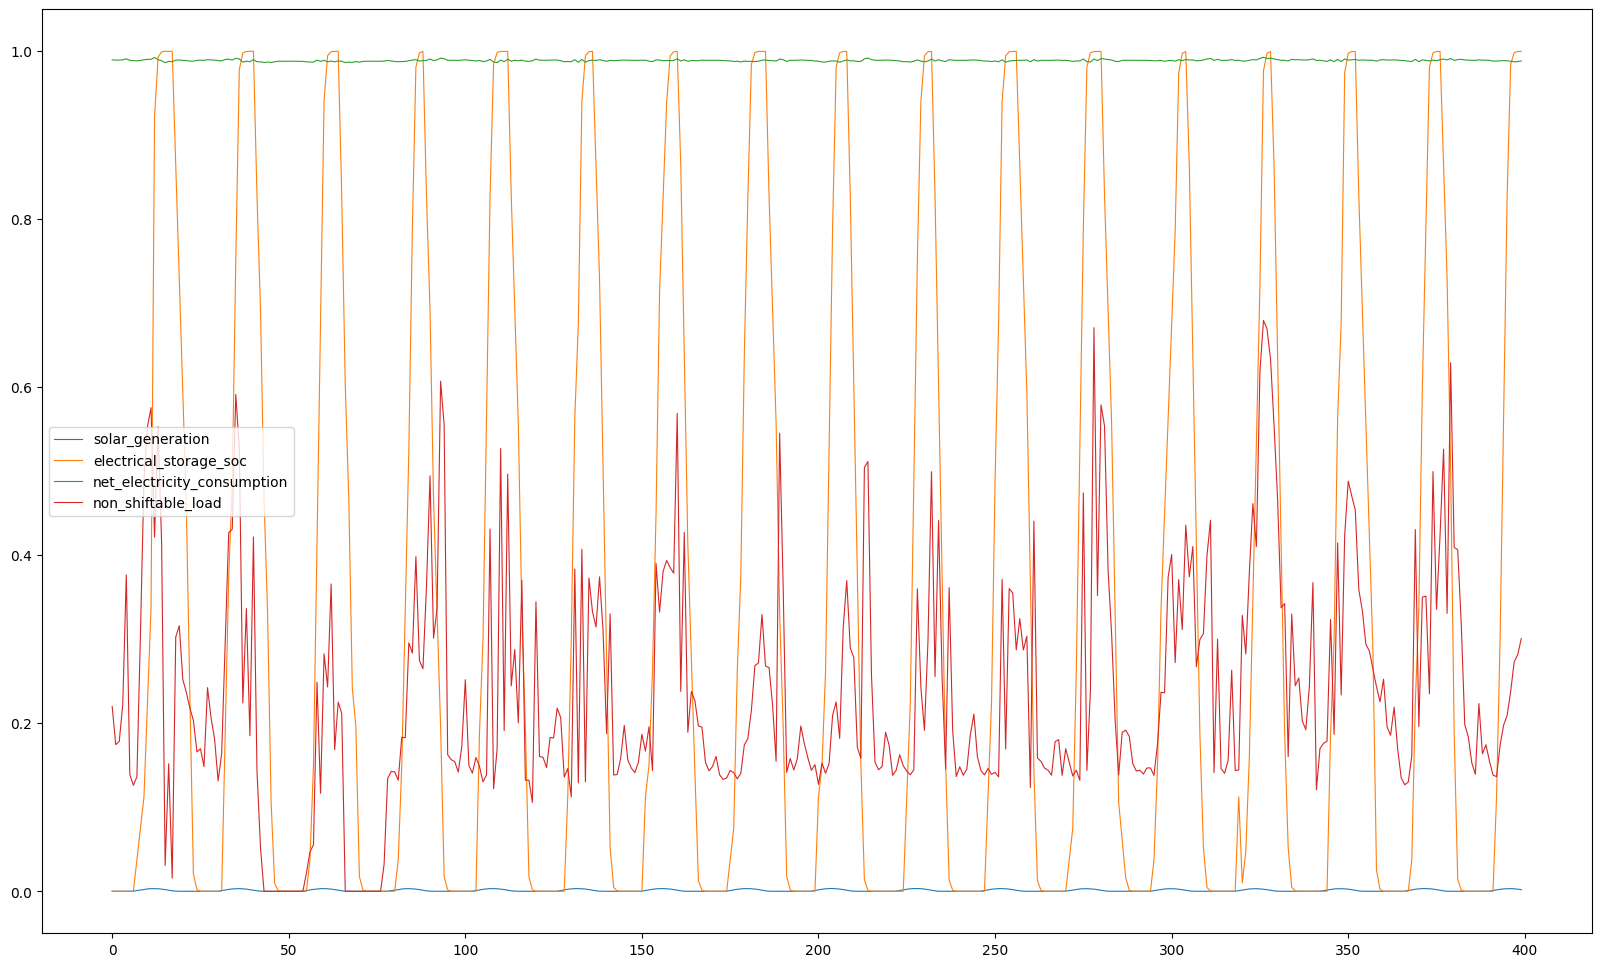

In [32]:
df_adv_obs[[#'outdoor_dry_bulb_temperature',
                 'solar_generation',
                 'electrical_storage_soc',
                 'net_electricity_consumption',
                 'non_shiftable_load',
                 #'electricity_pricing'
                 ]][:plot_len].plot.line(figsize=(20,12), lw=0.8)

<Axes: >

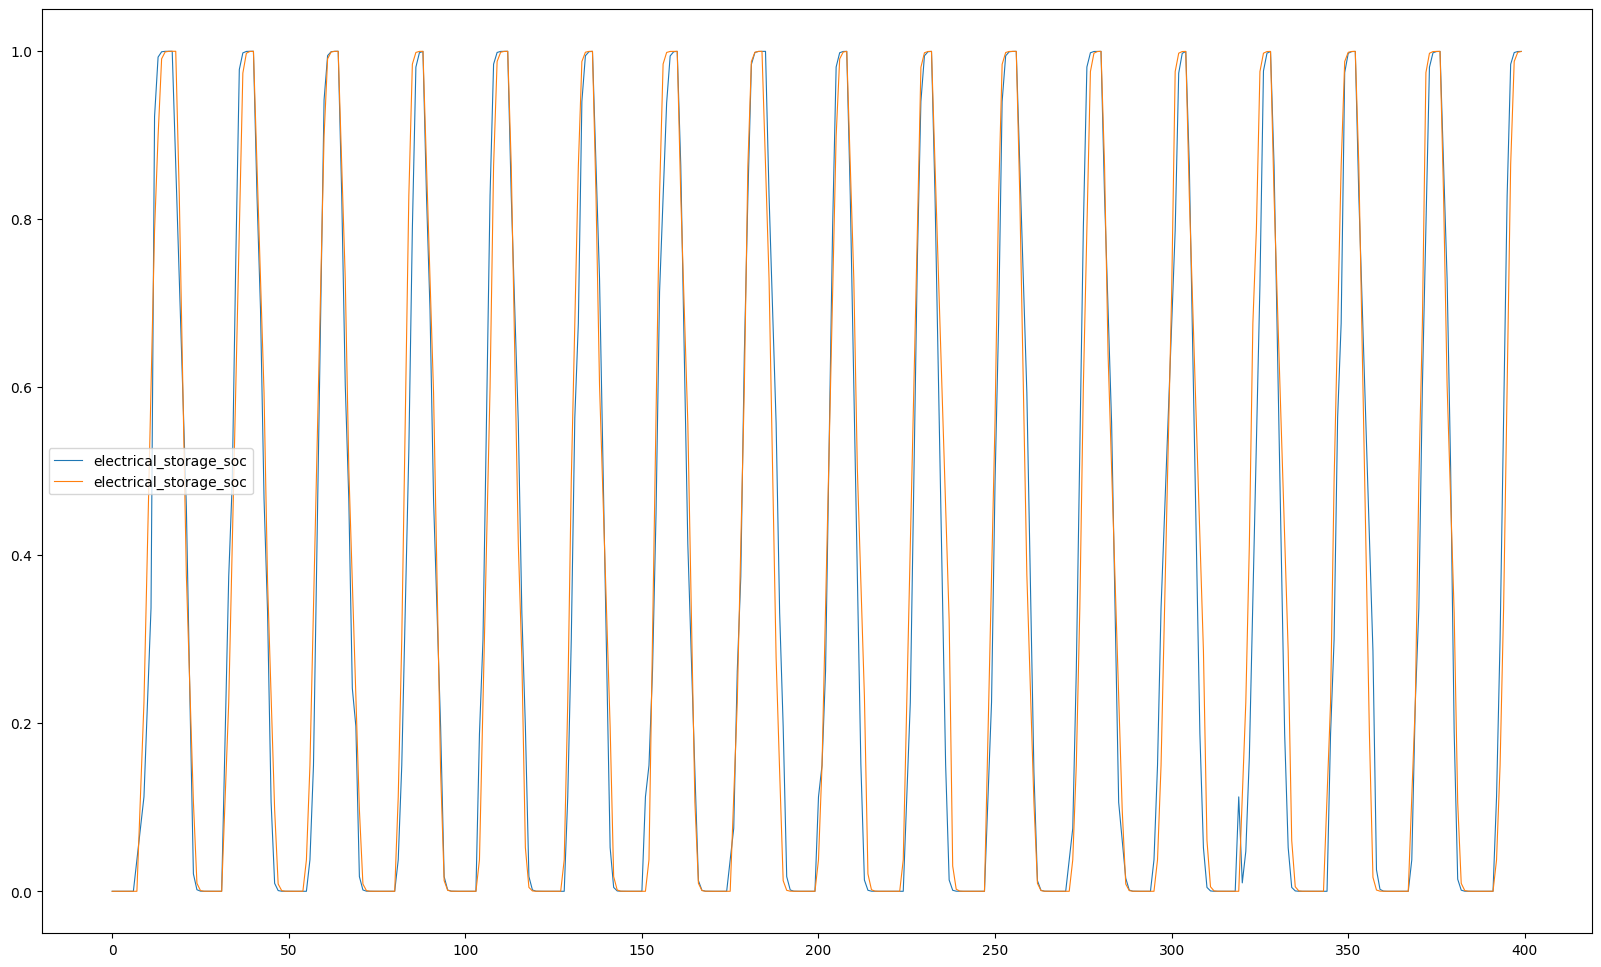

In [33]:
pd.concat([df_adv_obs['electrical_storage_soc'], df_baseline_obs['electrical_storage_soc']], axis=1)[:plot_len].plot.line(figsize=(20,12), lw=0.8)

Comparison of KPIs for all attacks

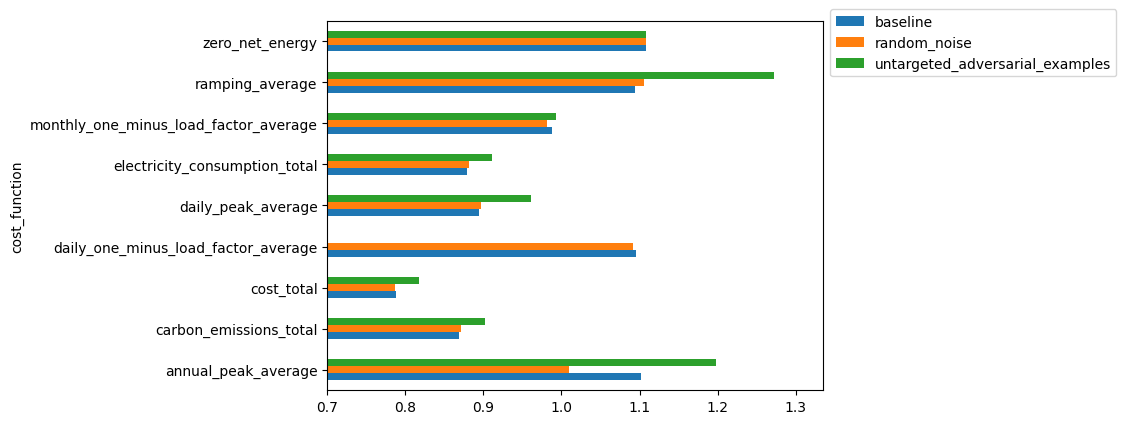

In [34]:
df_kpis = pd.concat([baseline_kpis, rand_kpis, Adv_untargered_kpis], axis=1)
df_kpis.columns = ['baseline','random_noise','untargeted_adversarial_examples']
df_kpis.plot.barh(xlim=0.7).legend(bbox_to_anchor=(1.0, 1.05))

We can plot the KPIs where the adversarial examples worse performance.The victim agent was trained to minimize energy consumption, and below we see the untargeted adversarial attack has increased the power consumption whihle the effects of the random attack were negligable.

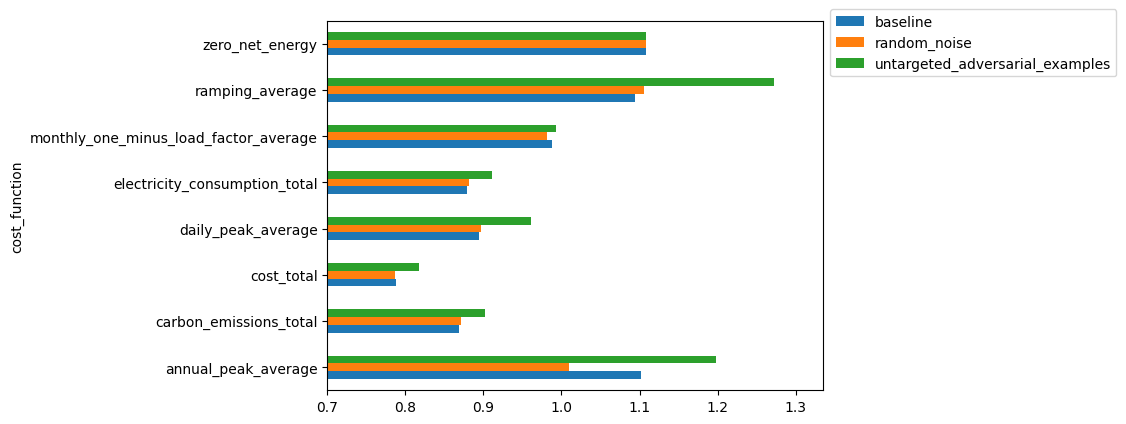

In [35]:
df_kpis[df_kpis['baseline'] < df_kpis['untargeted_adversarial_examples']].plot.barh(xlim=0.7).legend(bbox_to_anchor=(1.0, 1.05))

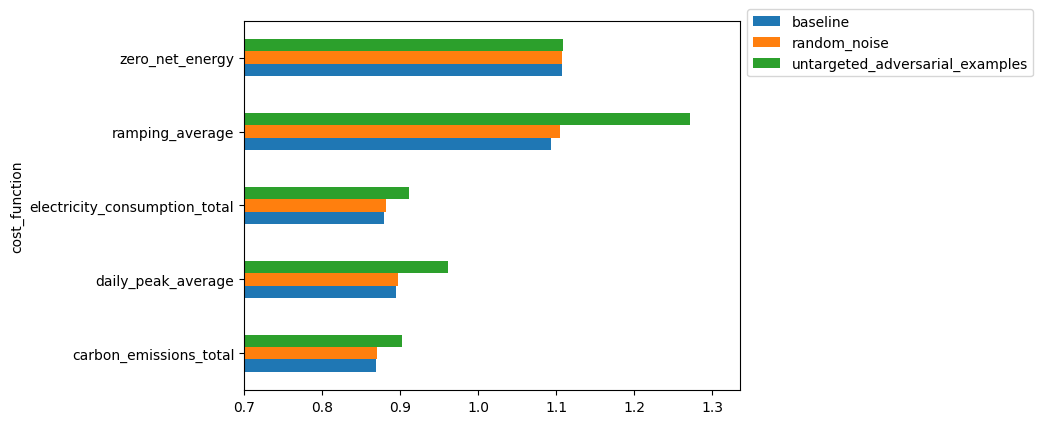

In [36]:
df_kpis[df_kpis['baseline'] < df_kpis['random_noise']].plot.barh(xlim=0.7).legend(bbox_to_anchor=(1.0, 1.05))

Value based adversarial attack:

This attack only adds perturbations when the value function is above the mean/median for a normal epidsode (98m):

In [38]:
Adv_v50_untargered_kpis, adv_v50_obs, adv_v50_eps = utils.eval_untargeted_dynamic_distortion_value_attack(agent,
                                                            env,
                                                            ART_atk=ACG,
                                                            ART_atk_kwargs=ACG_parameters,
                                                            eps_candidates=eps_list,
                                                            time_steps=None,
                                                            mask=observation_masks['mask_time'].to_numpy())
display(Adv_v50_untargered_kpis)

  0%|          | 0/8759 [00:00<?, ?it/s]

100%|█████████▉| 8758/8759 [1:59:09<00:00,  1.22it/s]  


The Adversarial success rate is: 0.9852741277752606
The perturbation rate was: 0.5039388057997488


cost_function
annual_peak_average                      1.102271
carbon_emissions_total                   0.891469
cost_total                               0.805982
daily_one_minus_load_factor_average      1.002500
daily_peak_average                       0.930231
electricity_consumption_total            0.901177
monthly_one_minus_load_factor_average    0.987415
ramping_average                          1.196971
zero_net_energy                          1.109079
Name: District, dtype: float64

This attack results in nearly idendical electircity consumption and a slightly smaller cost. Both are higher than the normal cases

<Axes: >

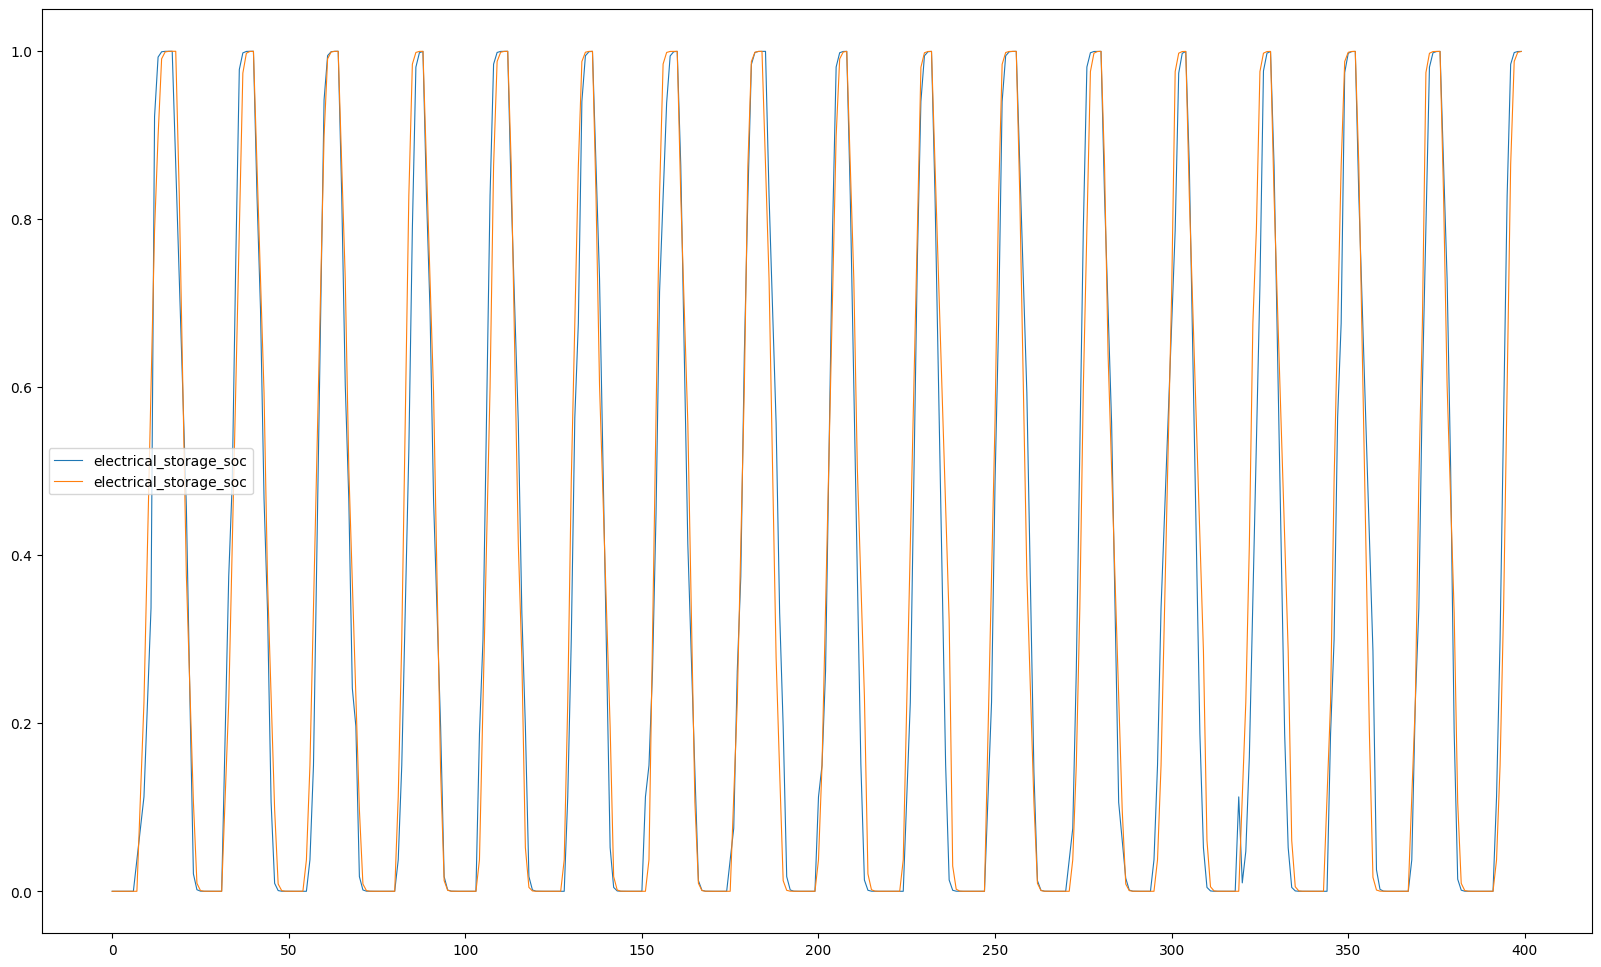

In [39]:
df_adv_v50_obs = pd.DataFrame(adv_obs, columns=observation_names)
pd.concat([df_adv_v50_obs['electrical_storage_soc'], df_baseline_obs['electrical_storage_soc']], axis=1)[:plot_len].plot.line(figsize=(20,12), lw=0.8)

<Axes: >

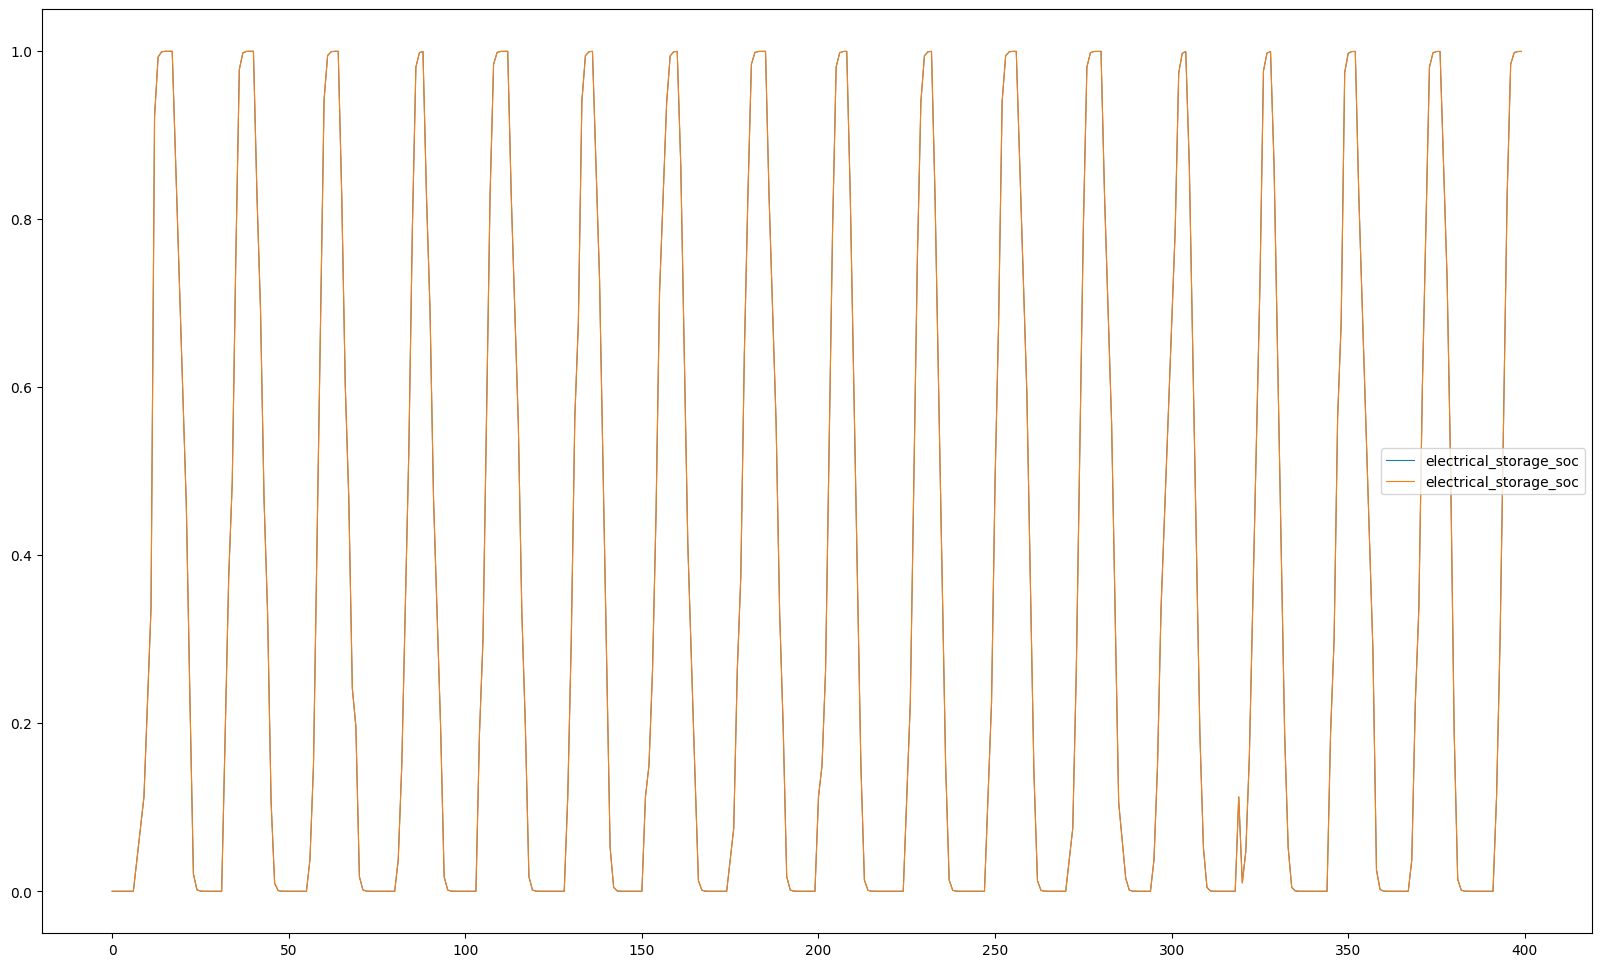

In [40]:
df_adv_v50_obs = pd.DataFrame(adv_obs, columns=observation_names)
pd.concat([df_adv_v50_obs['electrical_storage_soc'], df_adv_obs['electrical_storage_soc']], axis=1)[:plot_len].plot.line(figsize=(20,12), lw=0.8)

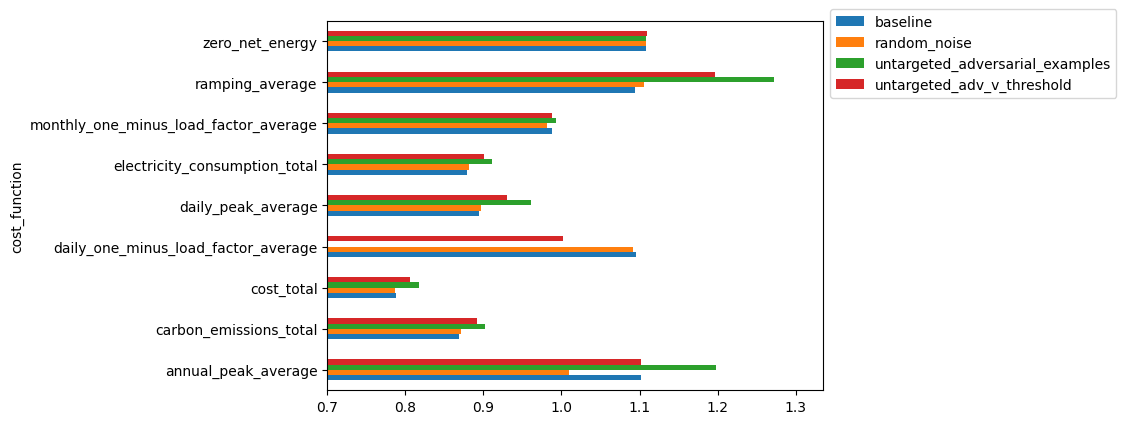

In [42]:
df_kpis = pd.concat([baseline_kpis, rand_kpis, Adv_untargered_kpis, Adv_v50_untargered_kpis], axis=1)
df_kpis.columns = ['baseline','random_noise','untargeted_adversarial_examples','untargeted_adv_v_threshold']
df_kpis.plot.barh(xlim=0.7).legend(bbox_to_anchor=(1.0, 1.05))

for the first 400 ts we see little difference between the actions take with or without a value threshold

<Axes: >

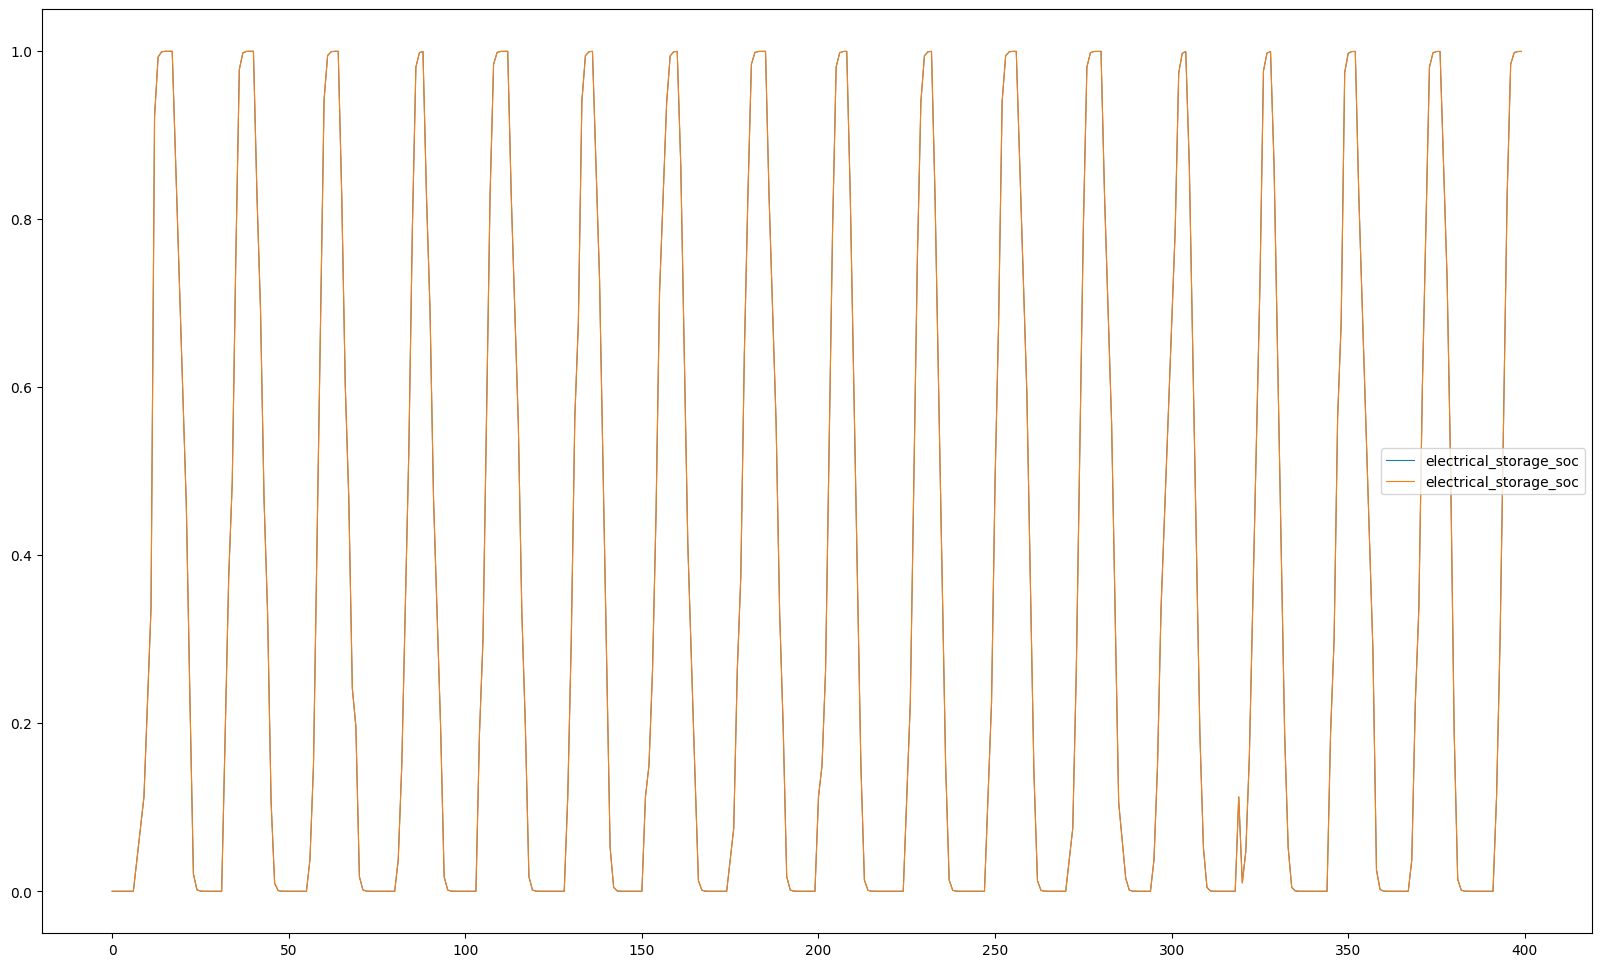

In [43]:
pd.concat([df_adv_obs['electrical_storage_soc'], df_adv_v50_obs['electrical_storage_soc']], axis=1)[:plot_len].plot.line(figsize=(20,12), lw=0.8)

We'll repeat the experiment for the 25% threshold (158m):

In [44]:
v25_percent = -93.6
Adv_v25_untargered_kpis, adv_v25_obs, adv_v25_eps = utils.eval_untargeted_dynamic_distortion_value_attack(agent,
                                                            env,
                                                            ART_atk=ACG,
                                                            ART_atk_kwargs=ACG_parameters,
                                                            eps_candidates=eps_list,
                                                            time_steps=None,
                                                            mask=observation_masks['mask_time'].to_numpy(),
                                                            value_threshold=v25_percent)
display(Adv_v25_untargered_kpis)

100%|█████████▉| 8758/8759 [2:53:01<00:01,  1.19s/it]  


The Adversarial success rate is: 0.9891669209642966
The perturbation rate was: 0.7482589336682269


cost_function
annual_peak_average                      1.102270
carbon_emissions_total                   0.900611
cost_total                               0.814078
daily_one_minus_load_factor_average      0.997434
daily_peak_average                       0.945812
electricity_consumption_total            0.909467
monthly_one_minus_load_factor_average    0.991820
ramping_average                          1.230539
zero_net_energy                          1.108982
Name: District, dtype: float64

In [45]:
df_adv_v25_obs = pd.DataFrame(adv_v25_obs, columns=env.observation_names[0])

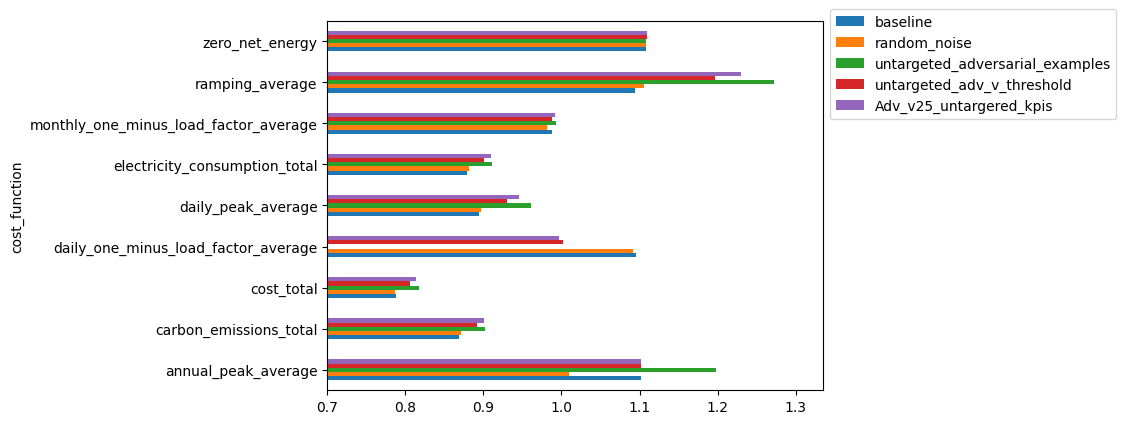

In [47]:
df_kpis = pd.concat([baseline_kpis, rand_kpis, Adv_untargered_kpis, Adv_v50_untargered_kpis, Adv_v25_untargered_kpis], axis=1)
df_kpis.columns = ['baseline','random_noise','untargeted_adversarial_examples','untargeted_adv_v_threshold', 'Adv_v25_untargered_kpis']
df_kpis.plot.barh(xlim=0.7).legend(bbox_to_anchor=(1.0, 1.05))

Now we'll try a smaller threshold for 25% of the step in a normal episode (53m):

In [49]:
v75_percent = -24.0
Adv_v75_untargered_kpis, adv_v75_obs, adv_v75_eps = utils.eval_untargeted_dynamic_distortion_value_attack(agent,
                                                            env,
                                                            ART_atk=ACG,
                                                            ART_atk_kwargs=ACG_parameters,
                                                            eps_candidates=eps_list,
                                                            time_steps=None,
                                                            mask=observation_masks['mask_time'].to_numpy(),
                                                            value_threshold=v75_percent)
display(Adv_v75_untargered_kpis)

100%|█████████▉| 8758/8759 [1:03:27<00:00,  2.30it/s]  


The Adversarial success rate is: 0.984077841662981
The perturbation rate was: 0.25813449023861174


cost_function
annual_peak_average                      1.102271
carbon_emissions_total                   0.880414
cost_total                               0.799415
daily_one_minus_load_factor_average      0.365708
daily_peak_average                       0.913327
electricity_consumption_total            0.890338
monthly_one_minus_load_factor_average    0.986949
ramping_average                          1.151861
zero_net_energy                          1.108470
Name: District, dtype: float64

wrong KPIS above

In [50]:
df_adv_v75_obs = pd.DataFrame(adv_v75_obs, columns=env.observation_names[0])

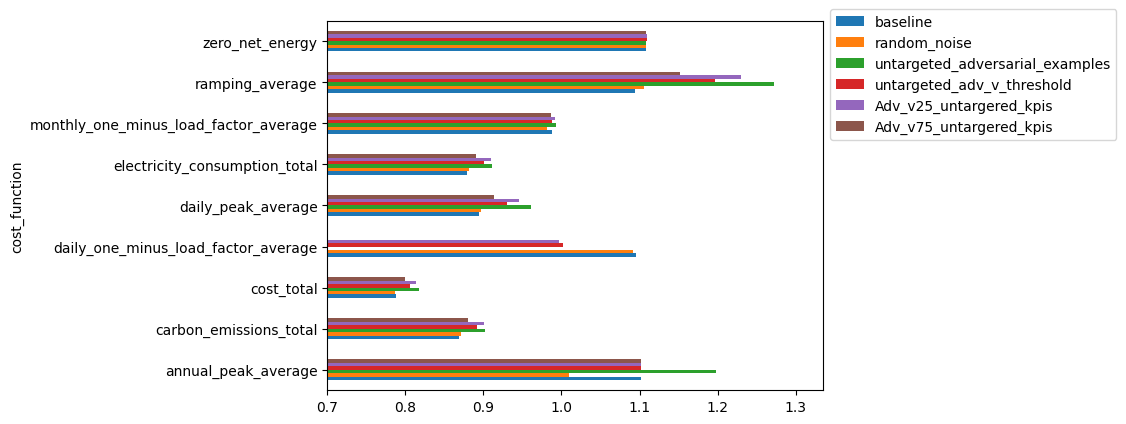

In [52]:
df_kpis = pd.concat([baseline_kpis, rand_kpis, Adv_untargered_kpis, Adv_v50_untargered_kpis, Adv_v25_untargered_kpis,Adv_v75_untargered_kpis ], axis=1)
df_kpis.columns = ['baseline','random_noise','untargeted_adversarial_examples','untargeted_adv_v_threshold', 'Adv_v25_untargered_kpis','Adv_v75_untargered_kpis']
df_kpis.plot.barh(xlim=0.7).legend(bbox_to_anchor=(1.0, 1.05))

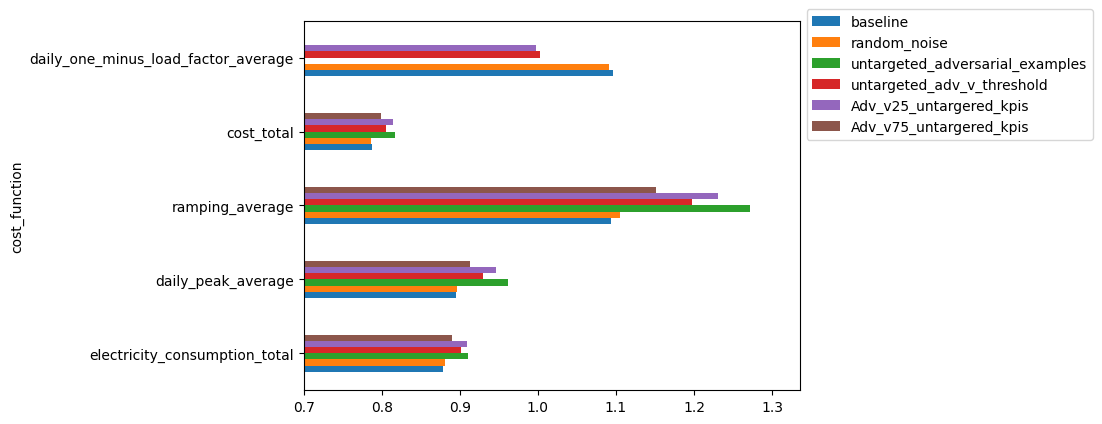

In [54]:
df_kpis.loc[['electricity_consumption_total','daily_peak_average','ramping_average','cost_total','daily_one_minus_load_factor_average']].plot.barh(xlim=0.7).legend(bbox_to_anchor=(1.0, 1.05))

In [55]:
df_kpis

,baseline,random_noise,untargeted_adversarial_examples,untargeted_adv_v_threshold,Adv_v25_untargered_kpis,Adv_v75_untargered_kpis
cost_function,,,,,,
annual_peak_average,1.102271,1.009338,1.198347,1.102271,1.102270,1.102271
carbon_emissions_total,0.869186,0.870929,0.902045,0.891469,0.900611,0.880414
cost_total,0.787803,0.786467,0.816997,0.805982,0.814078,0.799415
daily_one_minus_load_factor_average,1.095762,1.091588,0.397182,1.002500,0.997434,0.365708
daily_peak_average,0.894595,0.896781,0.961207,0.930231,0.945812,0.913327
electricity_consumption_total,0.879108,0.881392,0.910717,0.901177,0.909467,0.890338
monthly_one_minus_load_factor_average,0.988364,0.981307,0.992850,0.987415,0.991820,0.986949
ramping_average,1.093749,1.105215,1.271853,1.196971,1.230539,1.151861
zero_net_energy,1.107710,1.107912,1.108499,1.109079,1.108982,1.108470


This test uses randomly selects observations to perturb with a 50% probability, as a comparison to the test with a mean value threshold:

In [56]:
%%time
df_v_ablation_kpis, v_ablation_obs, v_ablation_eps = utils.eval_untargeted_dynamic_distortion_rand_attack(agent, 
                                                            env,
                                                            ART_atk=ACG,
                                                            ART_atk_kwargs=ACG_parameters,
                                                            eps_candidates=eps_list,
                                                            time_steps=None,
                                                            mask=observation_masks['mask_time'].to_numpy(), 
                                                            rand_threshold=0.5)
display(df_v_ablation_kpis)

100%|█████████▉| 8758/8759 [1:49:24<00:00,  1.33it/s]  


The Adversarial success rate is: 0.9914007694048427
The perturbation rate was: 0.5045096472200022


cost_function
annual_peak_average                      1.068404
carbon_emissions_total                   0.889796
cost_total                               0.806549
daily_one_minus_load_factor_average      1.050107
daily_peak_average                       0.939143
electricity_consumption_total            0.898543
monthly_one_minus_load_factor_average    0.993147
ramping_average                          1.216366
zero_net_energy                          1.108584
Name: District, dtype: float64

CPU times: total: 1h 49min 21s
Wall time: 1h 49min 25s


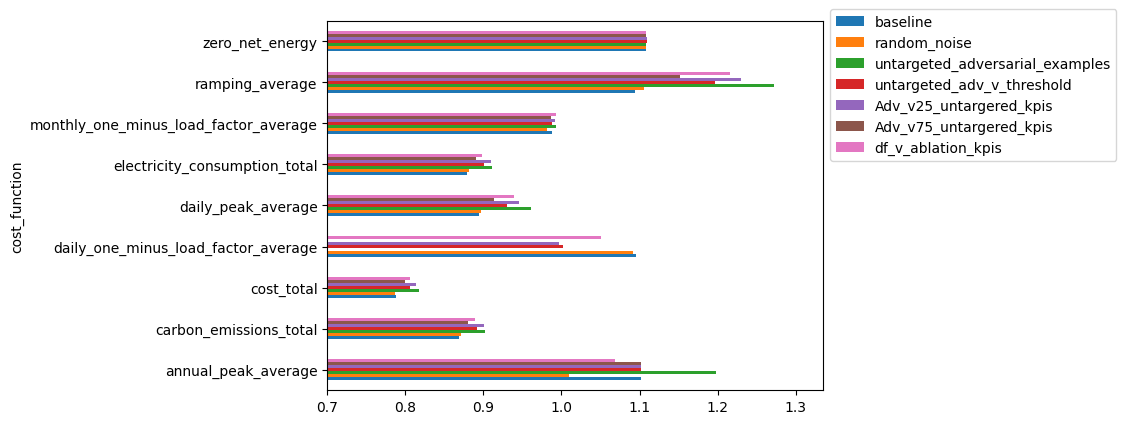

In [57]:
df_kpis = pd.concat([baseline_kpis, rand_kpis, Adv_untargered_kpis, Adv_v50_untargered_kpis, Adv_v25_untargered_kpis,Adv_v75_untargered_kpis, df_v_ablation_kpis], axis=1)
df_kpis.columns = ['baseline','random_noise','untargeted_adversarial_examples','untargeted_adv_v_threshold', 'Adv_v25_untargered_kpis','Adv_v75_untargered_kpis','df_v_ablation_kpis']
df_kpis.plot.barh(xlim=0.7).legend(bbox_to_anchor=(1.0, 1.05))

In [59]:
df_kpis

,baseline,random_noise,untargeted_adversarial_examples,untargeted_adv_v_threshold,Adv_v25_untargered_kpis,Adv_v75_untargered_kpis,df_v_ablation_kpis
cost_function,,,,,,,
annual_peak_average,1.102271,1.009338,1.198347,1.102271,1.102270,1.102271,1.068404
carbon_emissions_total,0.869186,0.870929,0.902045,0.891469,0.900611,0.880414,0.889796
cost_total,0.787803,0.786467,0.816997,0.805982,0.814078,0.799415,0.806549
daily_one_minus_load_factor_average,1.095762,1.091588,0.397182,1.002500,0.997434,0.365708,1.050107
daily_peak_average,0.894595,0.896781,0.961207,0.930231,0.945812,0.913327,0.939143
electricity_consumption_total,0.879108,0.881392,0.910717,0.901177,0.909467,0.890338,0.898543
monthly_one_minus_load_factor_average,0.988364,0.981307,0.992850,0.987415,0.991820,0.986949,0.993147
ramping_average,1.093749,1.105215,1.271853,1.196971,1.230539,1.151861,1.216366
zero_net_energy,1.107710,1.107912,1.108499,1.109079,1.108982,1.108470,1.108584


From the graphs above and below, we see our random method is inferior to the value threshold with a similar perturbation rate.

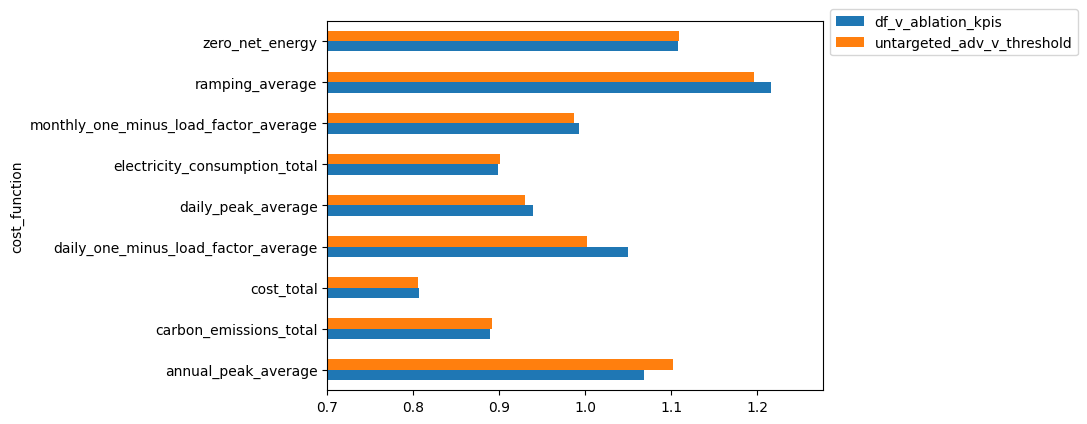

In [60]:
df_kpis[['df_v_ablation_kpis','untargeted_adv_v_threshold']].plot.barh(xlim=0.7).legend(bbox_to_anchor=(1.0, 1.05))

In [61]:
df_eps = pd.Series(adv_untargeted_eps)

Evaluate agent with variable epsilon:
- Start at min value and increase in loop
- try multiple values in parallel
- return stat on the eps used, box plot?